In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Image Classification Project

In this project, we aim to perform image classification using various CNN architectures. We will train and evaluate models such as ResNet, InceptionV3, EfficientNet, VGG, DenseNet, and MobileNet.

### Code Explanation

1. **Importing Libraries**: We start by importing the necessary libraries for the project, including NumPy, pandas, Matplotlib, and Torch.

2. **Setting the Device**: We set the device for training the models, checking if a GPU is available.

3. **Data Transformations**: We define the data transformations required for preprocessing the images, including resizing, data augmentation, and normalization.

4. **Loading the Datasets**: We load the training and testing datasets using the `ImageFolder` class.

5. **Creating Data Loaders**: We create data loaders to efficiently load the data during model training and evaluation.

6. **Training the Models**: We define the `train_model` function to train the CNN models using the specified architectures, criterion, optimizer, and number of epochs.

7. **Analyzing the Training Results**: We define the `analyze_training` function to visualize the training progress through loss and accuracy curves.

8. **Analyzing the Model Performance**: We define the `analyze_model` function to evaluate the model on the testing dataset, generate a confusion matrix, and print a classification report.

9. **Training and Evaluating the Models**: We instantiate and train specific CNN architectures, such as MobileNet and DenseNet, and analyze their performance.

### Conclusion

This code provides a framework for image classification using various CNN architectures. By training and evaluating different models, we can compare their performance and choose the most suitable one for our task.


In [1]:
!pip install virtualenv

# Create and activate a virtual environment
!virtualenv myenv
!source myenv/bin/activate

# Install required packages within the virtual environment
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.applications import ResNet50
from tensorflow.keras.callbacks import  ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

created virtual environment CPython3.10.10.final.0-64 in 1141ms
  creator CPython3Posix(dest=/kaggle/working/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.4.0, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import keras.backend as K

In [3]:
def f1_score(y_true,y_pred): #taken from old keras source code
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
    predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))
    precision=true_positives/(predicted_positives+K.epsilon())
    recall=true_positives/(possible_positives+K.epsilon())
    f1_val=2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [5]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

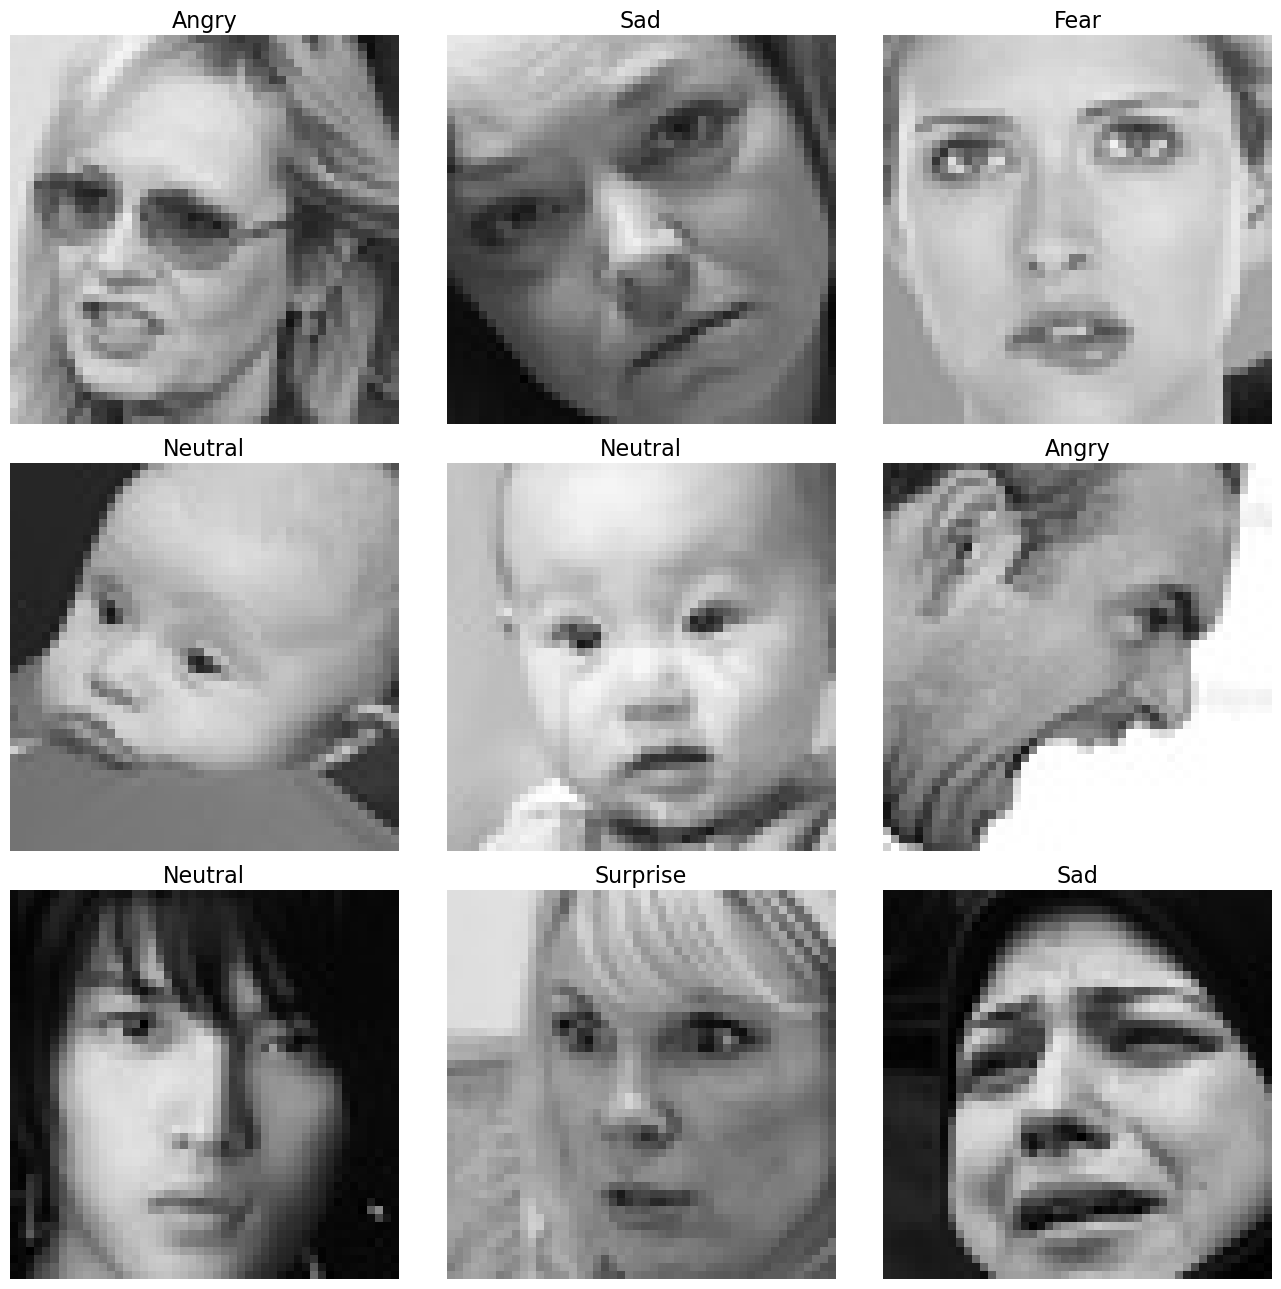

In [6]:
#Understanding dataset and Helper functions
train_dir='../input/fer2013/train'
test_dir='../input/fer2013/test'
class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
def display_one_image(image,title,subplot,color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title,fontsize=16)
    
def display_nine_images(images,titles,title_colors=None):
    subplot=331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color='black' if title_colors is None else title_colors[i]
        display_one_image(images[i],titles[i],331+i,color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.show()
    
def image_title(label,prediction):
    #Both prediction(probabilities) and label(one-hot) are arrays with one item per class
    class_idx=np.argmax(label,axis=-1)
    prediction_idx=np.argmax(prediction,axis=-1)
    if class_idx==prediction_idx:
        return f'{class_labels[prediction_idx]} [correct]','black'
    else:
        return f'{class_labels[prediction_idx]} [incorrect, should be {class_labels[class_idx]}]','red'
    
def get_titles(images,labels,model):
    predictions=model.predict(images)
    titles,colors=[],[]
    for label,prediction in zip(classes,predictions):
        title,color=image_title(label,prediction)
        titles.append(title)
        colors.append(color)
    return titles,colors

img_datagen=ImageDataGenerator(rescale=1./255)
img_generator=img_datagen.flow_from_directory(directory=train_dir,
                                             target_size=(48,48),
                                             batch_size=64,
                                             shuffle=True,
                                             color_mode="rgb",
                                             class_mode='categorical',
                                             seed=12
                                             )
clear_output()

images,classes=next(img_generator)
class_idxs=np.argmax(classes,axis=-1)
labels=[class_labels[idx] for idx in class_idxs]
display_nine_images(images,labels)

# **CNN**

## CNN Model for Image Classification

In this code, we will be implementing a Convolutional Neural Network (CNN) model for image classification. CNNs are powerful deep learning models commonly used for image analysis tasks. They consist of convolutional layers that extract relevant features from the input images, followed by pooling layers that downsample the feature maps. The extracted features are then flattened and passed through fully connected layers for classification. We will use various layers such as Conv2D, MaxPooling2D, Dropout, and Dense to construct our CNN model. The model will be trained on a dataset using data augmentation techniques to improve generalization. Finally, we will save the trained model and visualize the training progress and performance metrics.

In [63]:
# Data augmentation with ImageDataGenerator
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen_cnn = ImageDataGenerator(rescale=1./255)

# Load training data
train_data_cnn = train_datagen_cnn.flow_from_directory(
    directory='../input/fer2013/train',
    target_size=(50, 50),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

# Load testing data
test_data_cnn = test_datagen_cnn.flow_from_directory(
    directory='../input/fer2013/test',
    target_size=(50, 50),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [64]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)


In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                  

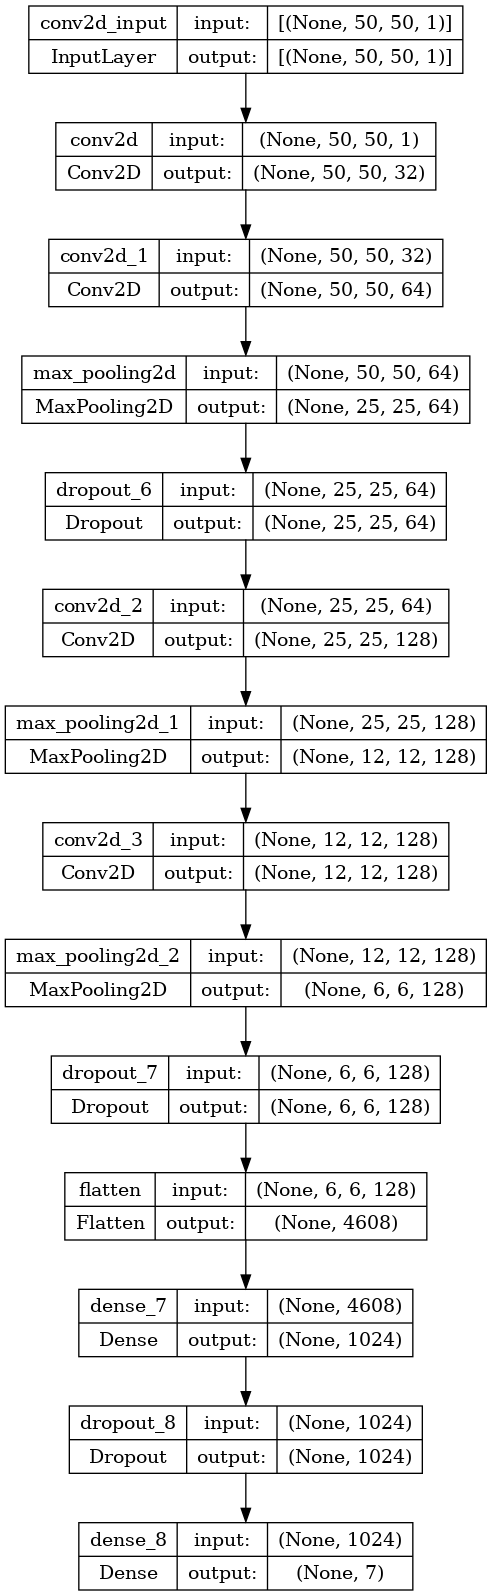

In [66]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
Image(filename='model.png')

In [12]:
#define callbacks
lrd=ReduceLROnPlateau(monitor='val_loss',patience=20,verbose=1,factor=0.50,min_lr=0.00005)
es=EarlyStopping(verbose=1,patience=20)
mcp1=ModelCheckpoint('model.h5')

In [68]:
cnn=model.fit(train_data_cnn,validation_data=test_data_cnn,epochs=60,verbose=1,callbacks=[lrd,mcp1,es])

Epoch 1/60


2023-07-04 09:19:14.973787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


449/449 [==============================] - 169s 374ms/step - loss: 1.8059 - accuracy: 0.8571 - precision: 0.2500 - recall: 3.4832e-05 - auc: 0.6536 - f1_score: 6.8528e-05 - val_loss: 1.7547 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7033 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/60
449/449 [==============================] - 52s 115ms/step - loss: 1.7224 - accuracy: 0.8575 - precision: 0.5591 - recall: 0.0133 - auc: 0.7088 - f1_score: 0.0252 - val_loss: 1.6217 - val_accuracy: 0.8603 - val_precision: 0.7112 - val_recall: 0.0371 - val_auc: 0.7572 - val_f1_score: 0.0673 - lr: 1.0000e-04
Epoch 3/60
449/449 [==============================] - 51s 114ms/step - loss: 1.6445 - accuracy: 0.8606 - precision: 0.6257 - recall: 0.0594 - auc: 0.7445 - f1_score: 0.1061 - val_loss: 1.5094 - val_accuracy: 0.8712 - val_precision: 0.7360 - val_recall: 0.1538 - val_auc: 0.7944 - val_f1_score: 0.2170 - lr: 1.0000e-04
Epoch 4/60
449/449 [================

In [70]:
# Save the model
model.save('path/to/save/cnn.h5')

In [72]:
tf.keras.utils.get_custom_objects()['f1_score'] = f1_score

In [73]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model1 = load_model('path/to/save/cnn.h5')

In [74]:
loaded_model1

In [22]:
#plotting results
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(20,5))
    fig.suptitle("MODEL'S METRICS VISUALIZATION ")
    
    ax1.plot(range(1,len(acc)+1),acc)
    ax1.plot(range(1,len(val_acc)+1),val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training','validation'])
    
    ax2.plot(range(1,len(loss)+1),loss)
    ax2.plot(range(1,len(val_loss)+1),val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training','validation'])
    
    ax3.plot(range(1,len(auc)+1),auc)
    ax3.plot(range(1,len(val_auc)+1),val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training','validation'])
    
    ax4.plot(range(1,len(precision)+1),precision)
    ax4.plot(range(1,len(val_precision)+1),val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training','validation'])
    
    ax5.plot(range(1,len(f1)+1),f1)
    ax5.plot(range(1,len(val_f1)+1),val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training','validation'])
    
    plt.show()

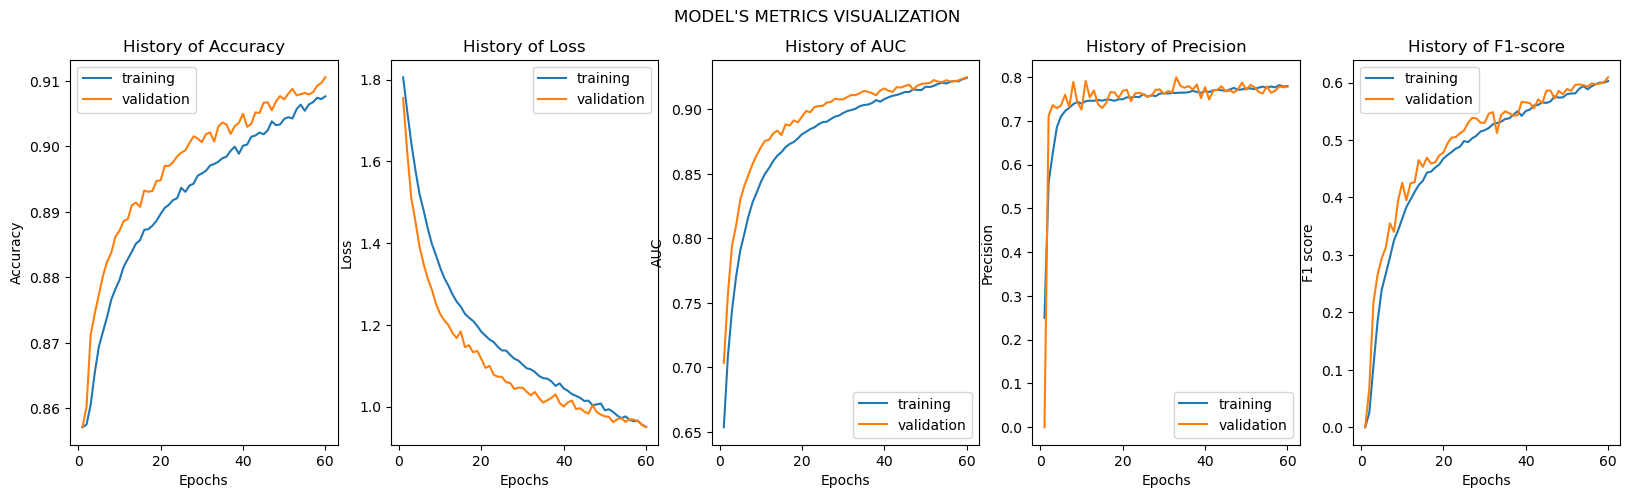

In [77]:
#plotting results
Train_Val_Plot(cnn.history['accuracy'],cnn.history['val_accuracy'],
               cnn.history['loss'],cnn.history['val_loss'],
               cnn.history['auc'],cnn.history['val_auc'],
               cnn.history['precision'],cnn.history['val_precision'],
               cnn.history['f1_score'],cnn.history['val_f1_score']
              )

# **RESNET**

# **ResNet Model for Image Classification**
In this code, we will be implementing a ResNet (Residual Network) model for image classification. ResNet is a deep convolutional neural network architecture known for its ability to handle the vanishing gradient problem in deep networks. We will be using the pre-trained ResNet50 model, which has been trained on the ImageNet dataset, as the base model. The top layers of the base model will be removed, and new layers will be added to adapt the model to our specific classification task.

Data augmentation techniques, such as rotation, shifting, flipping, and resizing, will be applied to the training dataset using the ImageDataGenerator class. This helps to increase the diversity and quantity of the training data, leading to better model generalization. The validation dataset will also be created using a validation split from the training data. The testing dataset will be loaded without any augmentation.

The ResNet model will have additional layers, including Dropout, BatchNormalization, and Dense layers, added on top of the base model. These layers help to improve the model's performance and generalization. The model will be trained using the Adam optimizer with a learning rate of 0.0001 and categorical cross-entropy as the loss function.

During training, the model's progress and performance metrics, such as accuracy, loss, AUC, precision, and F1-score, will be monitored and visualized using plots. The trained model will be saved for future use.

In [78]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                #zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [14]:
train_data=train_datagen.flow_from_directory(directory='../input/fer2013/train',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

Found 22968 images belonging to 7 classes.


In [15]:
test_data=test_datagen.flow_from_directory(directory='../input/fer2013/test',
                                             target_size=(48,48),
                                             batch_size=64,
                                             class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [81]:
IMG_SIZE = 48
# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model's layers
for layer in base_model.layers[:4]:
    layer.trainable = False
  

In [82]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Create the model
model_resnet=Sequential()
model_resnet.add(base_model)
model_resnet.add(Dropout(0.5))
model_resnet.add(Flatten())
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dense(len(CATEGORIES),activation='softmax'))

In [83]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_9 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                      

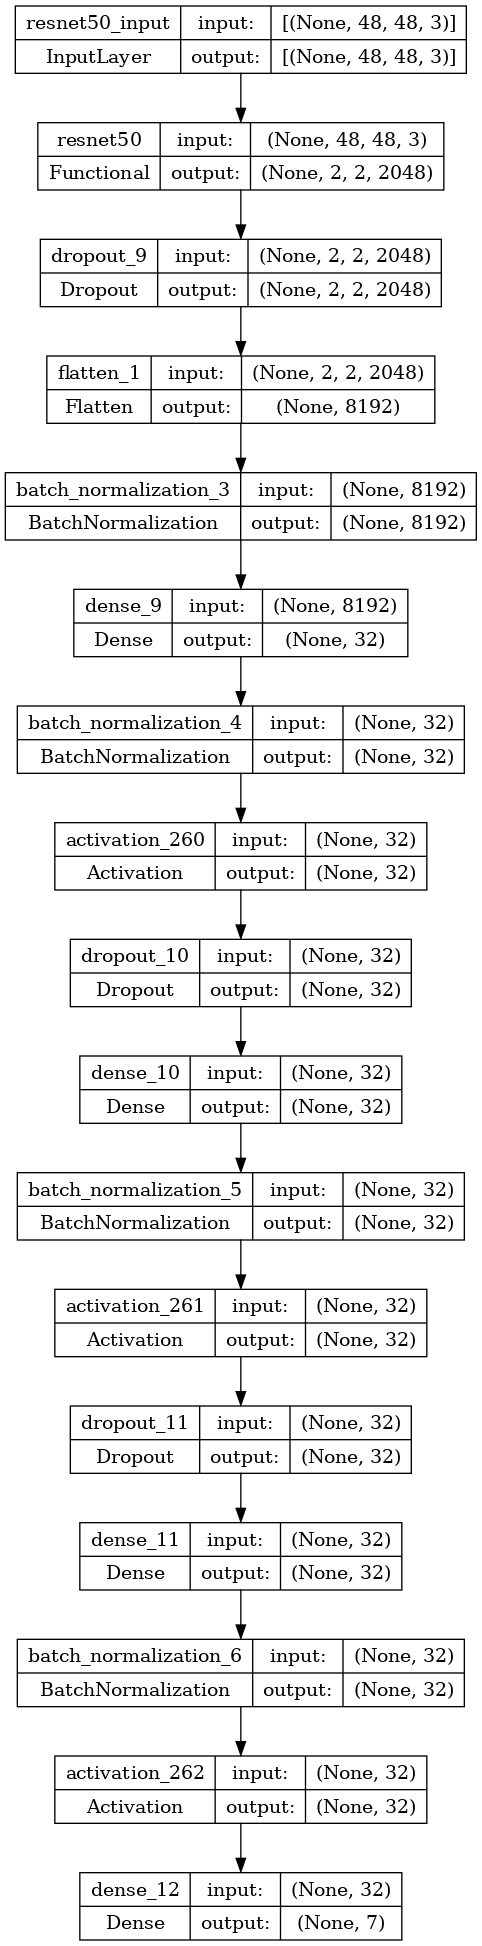

In [84]:
plot_model(model_resnet,to_file='model_resnet.png',show_shapes=True,show_layer_names=True)
Image(filename='model_resnet.png')

In [86]:
#compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)

In [87]:
# Save the model
model_resnet.save('path/to/save/model_resnet.h5')

In [88]:
resnet=model_resnet.fit(train_data,validation_data=test_data,epochs=60,verbose=1,callbacks=[lrd,mcp1,es])

Epoch 1/60


2023-07-04 10:31:48.058426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


359/359 [==============================] - 85s 213ms/step - loss: 2.0252 - accuracy: 0.8511 - precision: 0.2413 - recall: 0.0197 - auc: 0.5800 - f1_score: 0.0362 - val_loss: 70.1701 - val_accuracy: 0.7634 - val_precision: 0.1718 - val_recall: 0.1718 - val_auc: 0.5169 - val_f1_score: 0.1720 - lr: 1.0000e-04
Epoch 2/60
359/359 [==============================] - 60s 167ms/step - loss: 1.9157 - accuracy: 0.8545 - precision: 0.3690 - recall: 0.0256 - auc: 0.6226 - f1_score: 0.0477 - val_loss: 1.8646 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6119 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/60
359/359 [==============================] - 59s 165ms/step - loss: 1.8357 - accuracy: 0.8575 - precision: 0.5158 - recall: 0.0405 - auc: 0.6580 - f1_score: 0.0747 - val_loss: 2.5443 - val_accuracy: 0.8272 - val_precision: 0.1213 - val_recall: 0.0336 - val_auc: 0.5715 - val_f1_score: 0.0532 - lr: 1.0000e-04
Epoch 4/60
359/359 [========================

In [91]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model2 = load_model('path/to/save/model_resnet.h5')

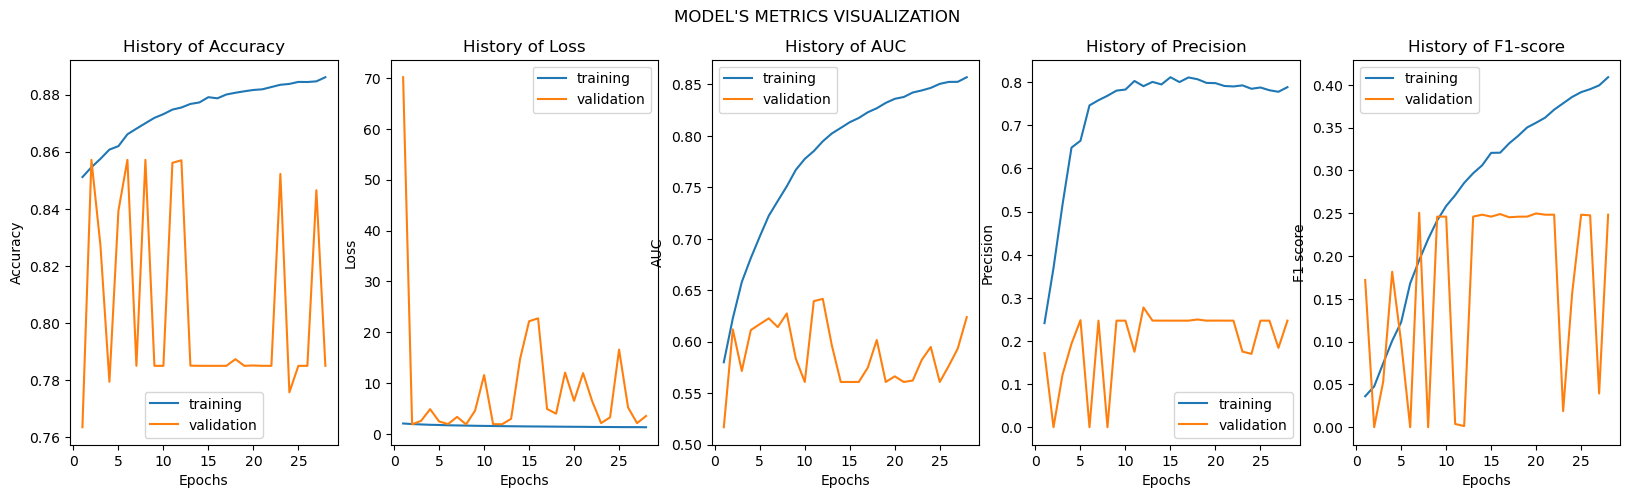

In [90]:
#plotting results
Train_Val_Plot(resnet.history['accuracy'],resnet.history['val_accuracy'],
               resnet.history['loss'],resnet.history['val_loss'],
               resnet.history['auc'],resnet.history['val_auc'],
               resnet.history['precision'],resnet.history['val_precision'],
               resnet.history['f1_score'],resnet.history['val_f1_score']
              )

# **INCEPTION_V3**

# **InceptionV3 Model for Image Classification**

In this code, we will be using the InceptionV3 model, a popular pre-trained convolutional neural network (CNN), for image classification. The InceptionV3 model is known for its ability to capture complex patterns and features in images. We will leverage transfer learning by loading the pre-trained InceptionV3 model with weights trained on the ImageNet dataset.

First, we instantiate the InceptionV3 model without the top layers, which allows us to add our own custom layers on top. We freeze the weights of the base model's layers to prevent them from being updated during training. We then add a global average pooling layer to reduce the spatial dimensions of the output feature maps. Dropout layers are added to mitigate overfitting, followed by dense layers for classification.

The model is compiled with an appropriate optimizer, learning rate, and loss function. Data augmentation techniques such as rotation, shifting, flipping, and rescaling are applied using the ImageDataGenerator class to increase the diversity of the training data and improve generalization. We create data generators for both the training and testing datasets.

The model is trained using the fit() function, specifying the training and testing data generators, number of epochs, verbosity level, and any desired callbacks. We also visualize the training progress and performance metrics using a custom plotting function.

By using the InceptionV3 model and transfer learning, we can efficiently classify images with high accuracy and leverage the pre-trained knowledge captured by the model on a large-scale dataset.

In [92]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

# Set the input image size
IMG_SIZE = 299

# Instantiate the InceptionV3 model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [93]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create the InceptionV3 model
model_inception = Model(inputs=base_model.input, outputs=x)

In [94]:
model_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [95]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_inception,to_file='model_inception.png',show_shapes=True,show_layer_names=True)
Image(filename='model_inception.png')

In [96]:
# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)

# Data generators
train_datagen_inception = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=5, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')
test_datagen_inception = ImageDataGenerator(rescale=1./255)

train_data_inception = train_datagen_inception.flow_from_directory(directory='../input/fer2013/train', target_size=(IMG_SIZE, IMG_SIZE),
                                              class_mode='categorical', subset='training', batch_size=64)
test_data_inception = test_datagen_inception.flow_from_directory(directory='../input/fer2013/test', target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=64, class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [97]:
# Train the model
inception = model_inception.fit(
    train_data_inception,
    validation_data=test_data_inception,
    epochs=10,
    verbose=1,
    callbacks=[lrd,mcp1,es]
)

Epoch 1/10
359/359 [==============================] - 562s 2s/step - loss: 1.9021 - accuracy: 0.8390 - precision: 0.2451 - recall: 0.0610 - auc: 0.5927 - f1_score: 0.0054 - val_loss: 1.8135 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6631 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - 548s 2s/step - loss: 1.8462 - accuracy: 0.8568 - precision: 0.3820 - recall: 0.0044 - auc: 0.6333 - f1_score: 0.0086 - val_loss: 1.7748 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6856 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - 554s 2s/step - loss: 1.8267 - accuracy: 0.8568 - precision: 0.4270 - recall: 0.0069 - auc: 0.6474 - f1_score: 0.0134 - val_loss: 1.7480 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6936 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/10
359/3

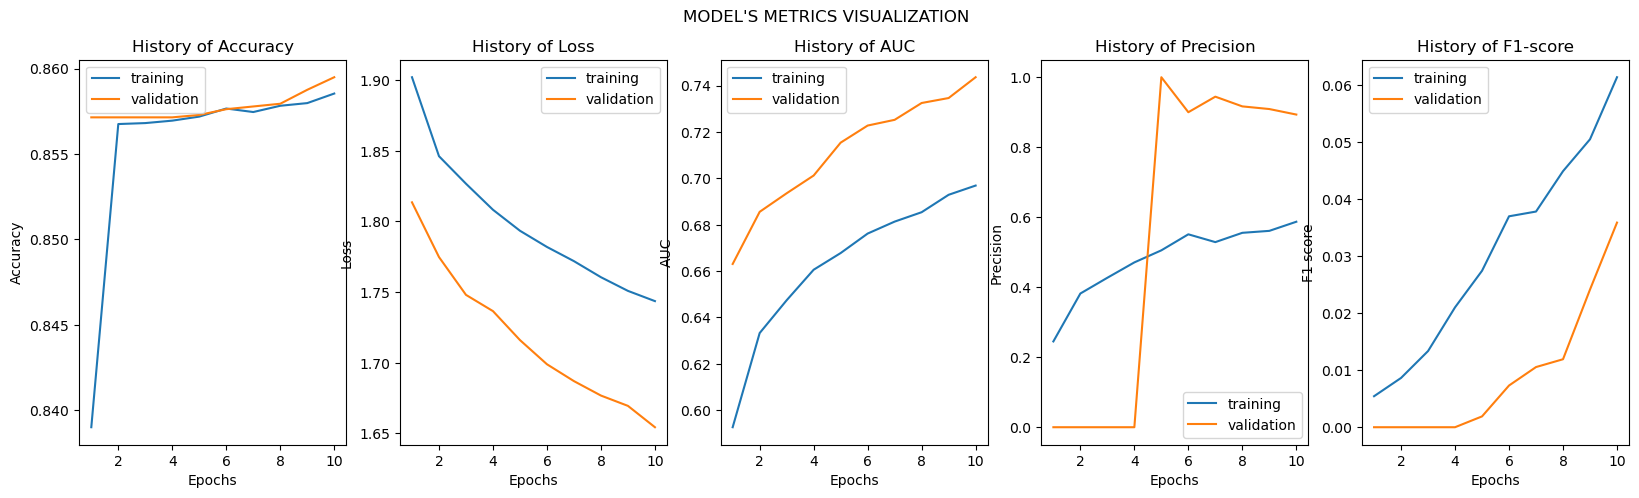

In [98]:
#plotting results
Train_Val_Plot(inception.history['accuracy'],inception.history['val_accuracy'],
               inception.history['loss'],inception.history['val_loss'],
               inception.history['auc'],inception.history['val_auc'],
               inception.history['precision'],inception.history['val_precision'],
               inception.history['f1_score'],inception.history['val_f1_score']
              )

# **EfficientNet**

# **EfficientNetB0 Model for Image Classification**

In this code, we will be implementing an EfficientNetB0 model for image classification. EfficientNet is a family of convolutional neural network models known for their high performance and efficiency. We will be using the EfficientNetB0 variant, which is the smallest and lightest model in the family.

First, we install and upgrade TensorFlow, the deep learning library. Then, we import the EfficientNetB0 model from the Keras applications module. We set the input image size to 224x224 pixels.

Next, we instantiate the EfficientNetB0 model with pre-trained weights from the ImageNet dataset. We set `include_top` to `False` to exclude the final fully connected layers. We freeze the first 100 layers of the base model to prevent their weights from being updated during training.

We add custom top layers to the base model to adapt it for our specific classification task. These layers include global average pooling, dropout for regularization, and dense layers with ReLU activation. The final dense layer has 7 units corresponding to the 7 classes in our dataset.

After creating the EfficientNet model, we compile it with the Adam optimizer, a learning rate of 0.0001, and categorical cross-entropy loss. We define the metrics to evaluate the model's performance.

To prepare the data, we use data generators provided by the ImageDataGenerator class. We perform data augmentation techniques such as rescaling, rotation, shifting, flipping, and zooming on the training set. The testing set is only rescaled.

We then create the data generators for both the training and testing sets. The `flow_from_directory` function is used to load and preprocess the images from the respective directories.

Finally, we train the EfficientNet model using the `fit` function, passing the training and testing data generators, specifying the number of epochs, and setting verbosity to 1. We visualize the training progress and performance metrics using the `Train_Val_Plot` function.

In [99]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [100]:
from tensorflow.keras.applications import EfficientNetB0

# Set the input image size
IMG_SIZE = 224

# Instantiate the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model's layers
for layer in base_model.layers[:100]:
    layer.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [101]:
# Add custom top layers
y = base_model.output
y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
y = Dense(32, activation='relu', kernel_initializer='he_uniform')(y)
y = Dropout(0.5)(y)
y = Dense(32, activation='relu', kernel_initializer='he_uniform')(y)
y = Dropout(0.5)(y)
y = Dense(32, activation='relu', kernel_initializer='he_uniform')(y)
y = Dropout(0.5)(y)
y = Dense(7, activation='softmax')(y)

In [102]:
# Create the EfficientNet model
model_efficientnet = Model(inputs=base_model.input, outputs=y)

model_efficientnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

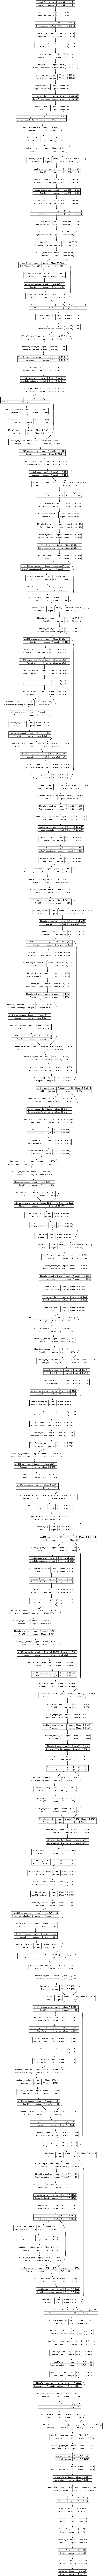

In [103]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_efficientnet,to_file='model_efficientnet.png',show_shapes=True,show_layer_names=True)
Image(filename='model_efficientnet.png')

In [104]:
mcp_efficientnet=ModelCheckpoint('model_efficientnet.h5')

In [105]:
# Compile the model
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)


In [106]:
# Data generators
train_datagen_efficientNet = ImageDataGenerator(rescale=1./255, validation_split=0.1, rotation_range=10, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.1,zoom_range=0.1, horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')
test_datagen_efficientNet = ImageDataGenerator(rescale=1./255)

train_data_efficientNet = train_datagen_efficientNet.flow_from_directory(directory='../input/fer2013/train', target_size=(IMG_SIZE, IMG_SIZE),
                                              class_mode='categorical', subset='training', batch_size=64)
test_data_efficientNet = test_datagen_efficientNet.flow_from_directory(directory='../input/fer2013/test', target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=64, class_mode='categorical')


Found 25841 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [107]:
# Train the model
efficientNet = model_efficientnet.fit(
    train_data_efficientNet,
    validation_data=test_data_efficientNet,
    epochs=20,
    verbose=1
)

Epoch 1/20


2023-07-04 13:03:35.382291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


404/404 [==============================] - 390s 942ms/step - loss: 1.9663 - accuracy: 0.8565 - precision: 0.3702 - recall: 0.0064 - auc: 0.6021 - f1_score: 0.0055 - val_loss: 1.9098 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6329 - val_f1_score: 0.0000e+00
Epoch 2/20
404/404 [==============================] - 373s 923ms/step - loss: 1.9067 - accuracy: 0.8569 - precision: 0.1831 - recall: 5.0308e-04 - auc: 0.6022 - f1_score: 9.8436e-04 - val_loss: 1.8680 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6458 - val_f1_score: 0.0000e+00
Epoch 3/20
404/404 [==============================] - 365s 904ms/step - loss: 1.8847 - accuracy: 0.8570 - precision: 0.1915 - recall: 3.4828e-04 - auc: 0.6182 - f1_score: 6.8545e-04 - val_loss: 1.8681 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6338 - val_f1_score: 0.0000e+00
Epoch 4/20
404/404 [==============================] -

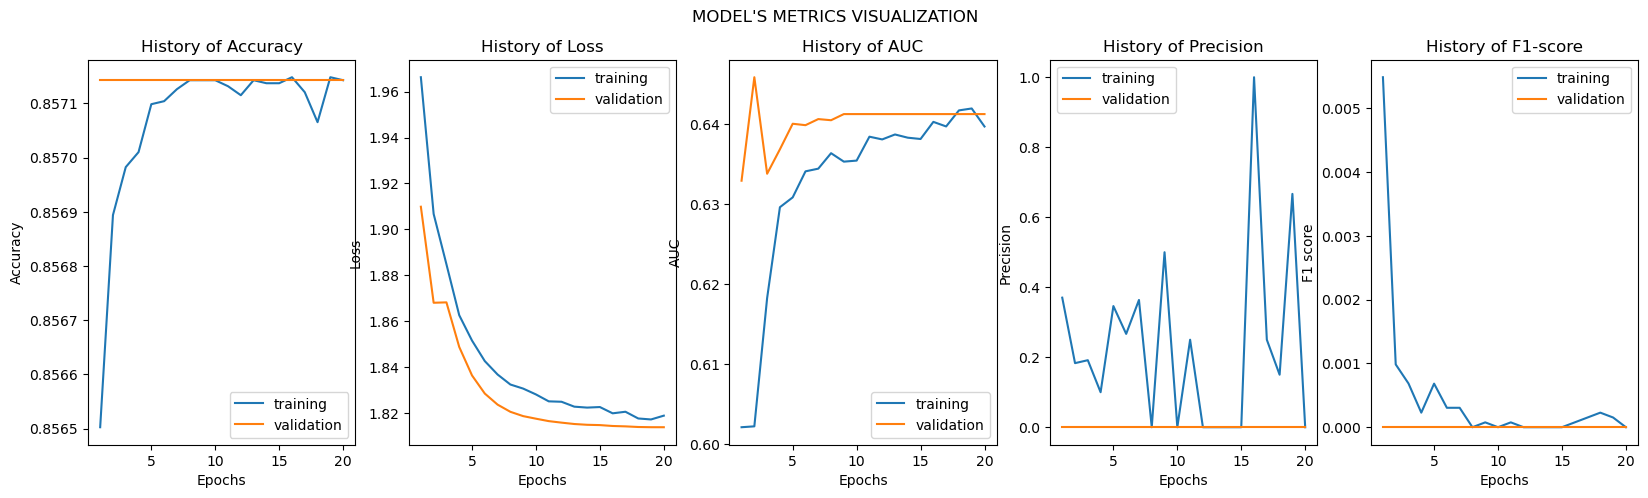

In [108]:
#plotting results
Train_Val_Plot(efficientNet.history['accuracy'],efficientNet.history['val_accuracy'],
               efficientNet.history['loss'],efficientNet.history['val_loss'],
               efficientNet.history['auc'],efficientNet.history['val_auc'],
               efficientNet.history['precision'],efficientNet.history['val_precision'],
               efficientNet.history['f1_score'],efficientNet.history['val_f1_score']
              )

# **VGG**

## **VGG Model for Image Classification**

In this code, we will be implementing a VGG (Visual Geometry Group) model for image classification. VGG is a popular deep learning architecture known for its simplicity and effectiveness. It consists of a series of convolutional layers with small filters followed by max-pooling layers to extract features from images. We will be using the pre-trained VGG16 model, which has been trained on a large dataset called ImageNet. We will freeze the pre-trained layers and add our own layers on top to perform classification. The added layers include dropout for regularization, batch normalization for normalization, and dense layers for classification. The model will be trained on a dataset using data augmentation techniques to improve generalization. Finally, we will evaluate the model's performance, visualize the confusion matrix, and calculate the ROC AUC score for multi-class classification.

In [11]:
from tensorflow.keras.applications import VGG16

train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                #zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)
train_dataset=train_datagen.flow_from_directory(directory='../input/fer2013/train',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)
test_dataset=test_datagen.flow_from_directory(directory='../input/fer2013/test',
                                             target_size=(48,48),
                                             batch_size=64,
                                             class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [110]:
base_model=tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights='imagenet')

#freezing layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [111]:
#Building model

model_vgg=Sequential()
model_vgg.add(base_model)
model_vgg.add(Dropout(0.5))
model_vgg.add(Flatten())
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dense(7,activation='softmax'))

In [112]:
model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_18 (Dropout)        (None, 1, 1, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_101 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 32)                16416     
                                                                 
 batch_normalization_102 (Ba  (None, 32)               128       
 tchNormalization)                                    

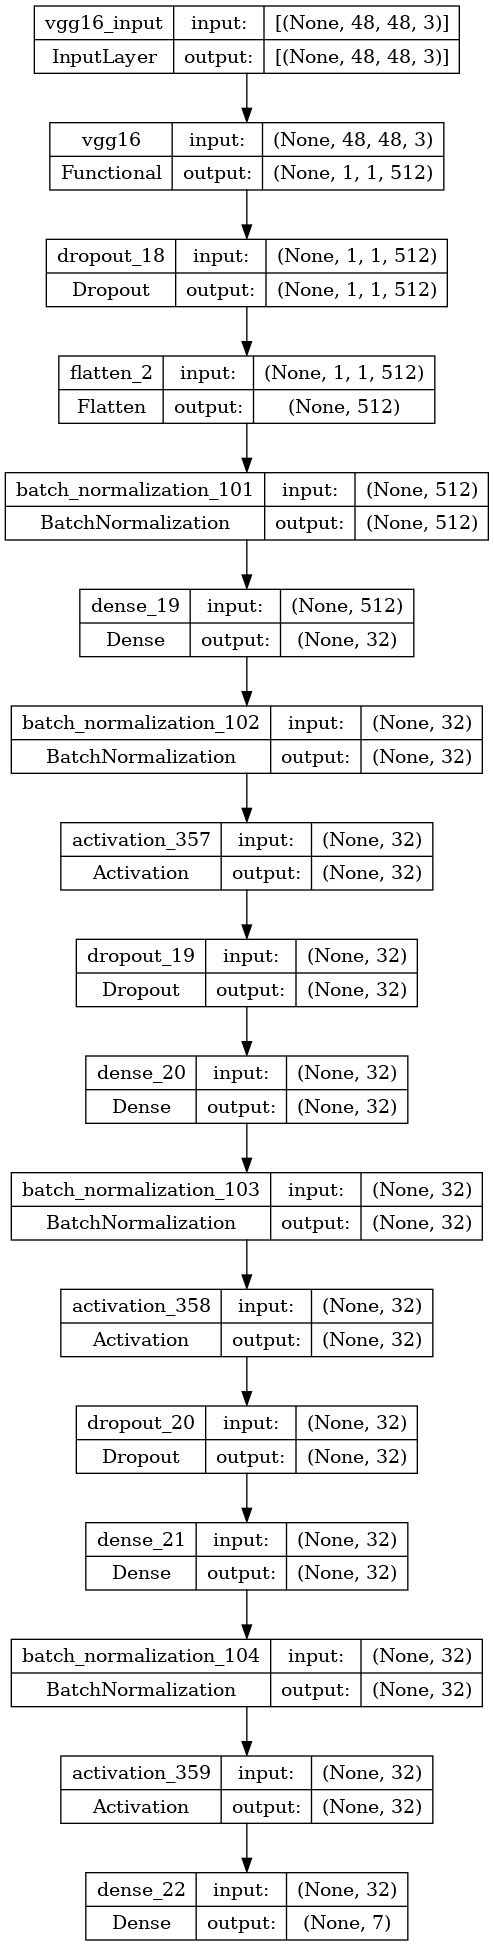

In [113]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_vgg,to_file='vgg.png',show_shapes=True,show_layer_names=True)
Image(filename='vgg.png')

In [114]:
mcp_vgg=ModelCheckpoint('model_vgg.h5')

In [115]:
model_vgg.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)


In [116]:
vgg=model_vgg.fit(train_dataset,validation_data=test_dataset,epochs=20,verbose=1,callbacks=[lrd,mcp_vgg,es])

Epoch 1/20


2023-07-04 15:12:20.026445: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


359/359 [==============================] - 66s 165ms/step - loss: 1.9489 - accuracy: 0.8560 - precision: 0.1618 - recall: 0.0019 - auc: 0.6007 - f1_score: 0.0047 - val_loss: 1.8036 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6570 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
359/359 [==============================] - 57s 159ms/step - loss: 1.8334 - accuracy: 0.8570 - precision: 0.2200 - recall: 4.7893e-04 - auc: 0.6360 - f1_score: 9.4279e-04 - val_loss: 1.8237 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6486 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
359/359 [==============================] - 56s 156ms/step - loss: 1.7968 - accuracy: 0.8571 - precision: 0.4800 - recall: 0.0042 - auc: 0.6618 - f1_score: 0.0082 - val_loss: 1.8625 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6419 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
359/359 [=====

113/113 [==============================] - 8s 66ms/step


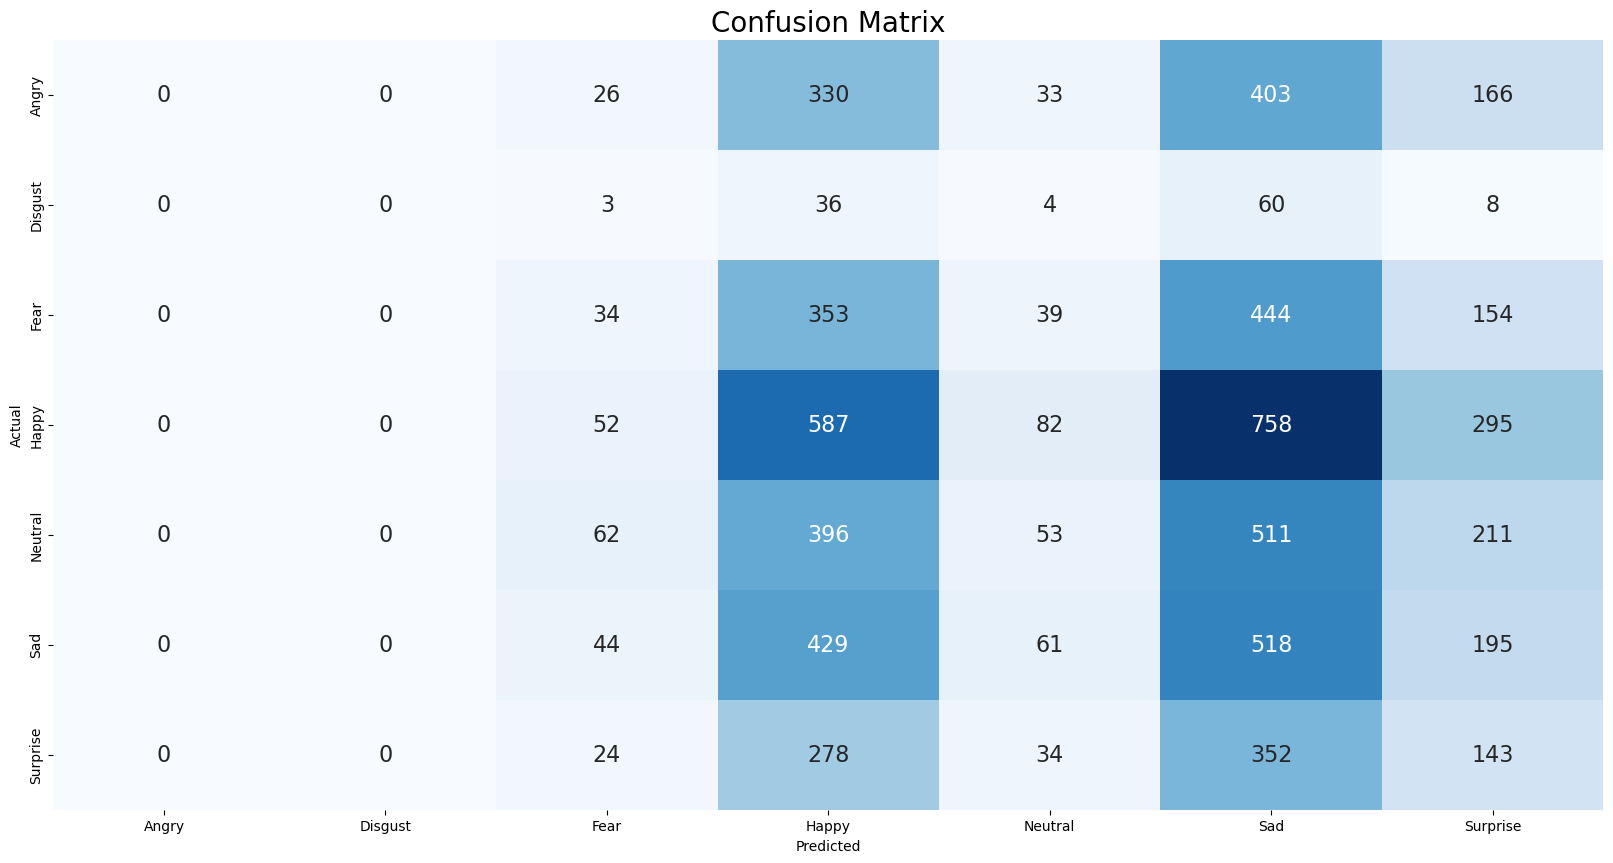

In [117]:
import seaborn as sn
train_dir='../input/fer2013/train'
test_dir='../input/fer2013/test'
classes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
y_test=np.array(test_data.labels)
vgg_acc=model_vgg.evaluate(test_data,verbose=0)[1]
preds=model_vgg.predict(test_data)
y_preds=np.argmax(preds,axis=1)
from sklearn.metrics import confusion_matrix,classification_report
cm_data_vgg=confusion_matrix(y_test,y_preds)
cm_vgg=pd.DataFrame(cm_data_vgg,columns=classes,index=classes)
cm_vgg.index.name="Actual"
cm_vgg.columns.name="Predicted"
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
sn.set(font_scale=1.2)
ax_vgg=sn.heatmap(cm_vgg,cbar=False,cmap="Blues",annot=True,annot_kws={"size":16},fmt='g')

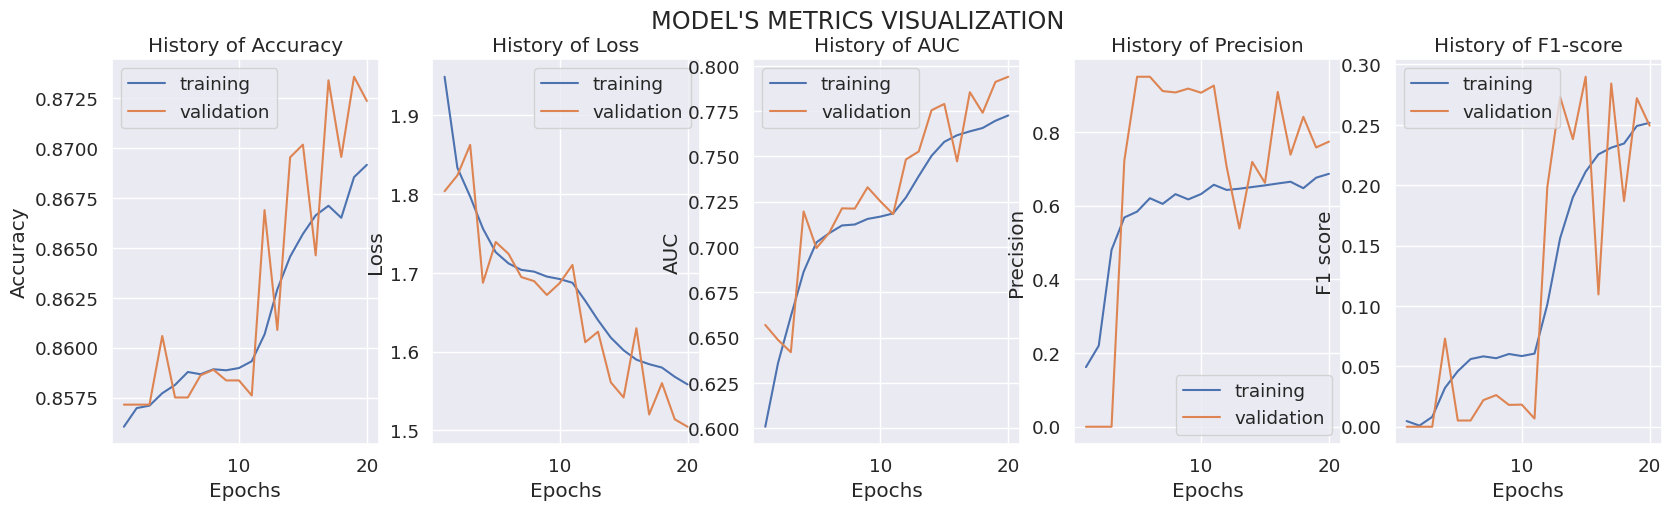

In [118]:
Train_Val_Plot(vgg.history['accuracy'],vgg.history['val_accuracy'],
               vgg.history['loss'],vgg.history['val_loss'],
               vgg.history['auc'],vgg.history['val_auc'],
               vgg.history['precision'],vgg.history['val_precision'],
               vgg.history['f1_score'],vgg.history['val_f1_score']
              )

In [ ]:
vgg_acc=model_vgg.evaluate(test_data,verbose=0)[1]
preds=model_vgg.predict(test_data)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_data.labels)
# vgg_model.save('vgg_model.h5')

ROC AUC score: 0.5860640144313698


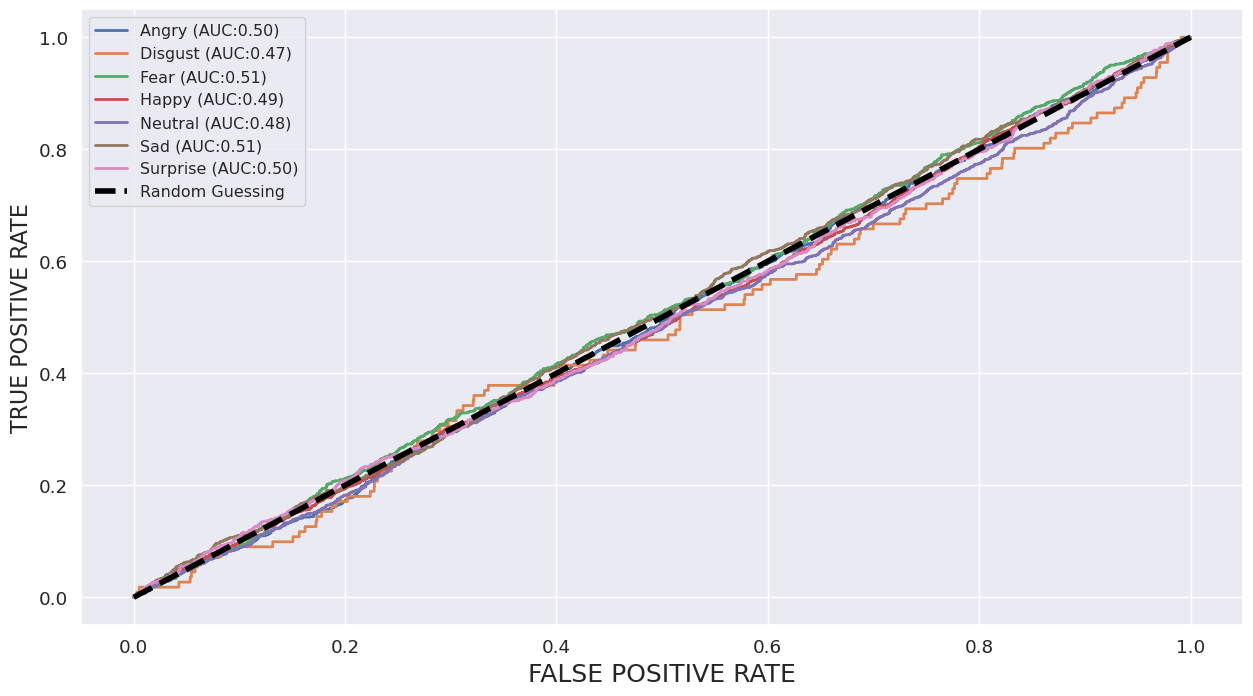

In [120]:
from sklearn.preprocessing import LabelBinarizer
fig,c_ax=plt.subplots(1,1,figsize=(15,8))
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score1(y_test,y_preds,average="macro"):
    lb=LabelBinarizer()
    lb.fit(y_test)
    y_test=lb.transform(y_test)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test[:,idx].astype(int),y_preds[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test,y_preds,average=average)

print('ROC AUC score:',multiclass_roc_auc_score1(y_test,preds,average='micro'))
plt.xlabel('FALSE POSITIVE RATE',fontsize=18)
plt.ylabel('TRUE POSITIVE RATE',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()


In [121]:
from tensorflow.keras.utils import to_categorical
print("ROC-AUC Score =",roc_auc_score(to_categorical(y_test),preds))

ROC-AUC Score = 0.49442612564313376


# **MobileNet**

## **MobileNet Model for Image Classification**

In this code, we will be using the MobileNet model for image classification. MobileNet is a lightweight convolutional neural network architecture designed for mobile and embedded devices. It provides a good balance between model size and accuracy, making it suitable for resource-constrained environments. 

The code begins by importing the necessary libraries and setting up the device for training (GPU if available, else CPU). It then defines the transformations to be applied to the training and testing data using `transforms.Compose`. These transformations include resizing, random horizontal flipping, random rotation, and normalization.

The dataset is loaded using `ImageFolder` and transformed using the defined transformations. Data loaders are created for both the training and testing data using `DataLoader`. 

Next, a function `train_model` is defined to train the MobileNet model. It takes the model, criterion, optimizer, and the number of epochs as input. The function loops over the specified number of epochs and performs training and testing for each epoch. It calculates the loss and accuracy for both training and testing phases and stores them in dictionaries. It also keeps track of the maximum accuracy achieved and saves the predictions and labels with the highest accuracy.

Another function `analyze_training` is defined to analyze the training progress. It plots the loss and accuracy per epoch using the stored data.

Finally, a function `analyze_model` is defined to analyze the trained model's performance. It evaluates the model on the test data, calculates the confusion matrix, classification report, and accuracy. It also plots the confusion matrix.

In the code, the MobileNet model is loaded with pre-trained weights and modified by replacing the last fully connected layer (`fc2`) with a new sequence of layers. The parameters of `fc2` are set to require gradients for fine-tuning. The model is then trained using the `train_model` function for a specified number of epochs. The trained model is then evaluated and the training progress is analyzed using the `analyze_model` and `analyze_training` functions, respectively.

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
train_dir = '../input/fer2013/train'
test_dir = '../input/fer2013/test'

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [8]:
train_data = ImageFolder(train_dir, transform=train_transform)
test_data = ImageFolder(test_dir, transform=test_transform)

In [9]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, pin_memory=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA_VISIBLE_DEVICES=0

In [11]:
def train_model(model, criterion, optimizer, num_epochs=3):
    losses = {'train': [],'test': []}
    accuracies = {'train': [],'test': []}
    max_accuracy = 0
    val_preds = []
    val_labels = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
           

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in train_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    #loss = V(loss, requires_grad = True)

                    optimizer.zero_grad()
                    loss.backward()

                    optimizer.step()

                    preds_proba = nn.functional.softmax(outputs, 1)
                    preds = torch.argmax(preds_proba, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                   

                epoch_loss = running_loss / len(
                    [phase])
                epoch_acc = running_corrects.double() / len(train_data)

                print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                            epoch_loss,
                                                            epoch_acc))
                losses[phase].append(epoch_loss)
                accuracies[phase].append(epoch_acc.item())

            else:
                model.eval()
                with torch.no_grad():
                    running_loss = 0.0
                    running_corrects = 0
                    epoch_preds = []
                    epoch_labels = []

                    for inputs, labels in test_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        #loss = V(loss, requires_grad = True)

                        preds_proba = nn.functional.softmax(outputs, 1)
                        preds = torch.argmax(preds_proba, 1)
                        running_loss += loss.item()
                        running_corrects += torch.sum(preds == labels.data)
                        epoch_preds+=preds.cpu().numpy().tolist()
                        epoch_labels+=labels.cpu().numpy().tolist()

                    epoch_loss = running_loss / len(test_data)
                    epoch_acc = running_corrects.double() / len(test_data)
                    
                    if epoch % 5 == 0:
                        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                epoch_loss,
                                                                epoch_acc))
                    losses[phase].append(epoch_loss)
                    accuracies[phase].append(epoch_acc.item())
                    if max_accuracy < epoch_acc:
                        max_accuracy = epoch_acc
                        val_preds = epoch_preds
                        val_labels = epoch_labels

            
    return {"model": model, 
            "losses": losses, 
            "accuracies": accuracies, 
            "val_preds": epoch_preds, 
            "val_labels": epoch_labels}

In [12]:
def analyze_training(training_result):
    # loss data
    losses_df = pd.DataFrame(trainin_output['losses'])
    losses_df.plot()
    plt.title('Loss per epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    # accuracy
    acc_df = pd.DataFrame(trainin_output['accuracies'])
    acc_df.plot()
    plt.title('Accuracy per epoch')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

In [13]:
def analyaze_model(model):
    model.eval()
    # Make predictions on the test data
    with torch.no_grad():
        predictions = []
        targets = []
        for batch in test_loader:
            images, labels = batch
            output = model(images.to(device))
            predictions.append(output.to('cpu').numpy())
            targets.append(labels.to('cpu').numpy())
        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)
    cm = confusion_matrix(targets, predictions.argmax(axis=1))
    report = classification_report(targets, predictions.argmax(axis=1))
    # Plot a confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(train_data.classes))
    plt.xticks(tick_marks, train_data.classes, rotation=45)
    plt.yticks(tick_marks, train_data.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    print(report)
    accuracy = (predictions.argmax(axis=1) == targets).mean()
    print('Accuracy:', accuracy)

In [14]:
mobilenet_model = models.mobilenet_v3_small(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, mobilenet_model.parameters()), lr=0.01)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 84.9MB/s]


In [15]:
mobilenet_model.fc2 = nn.Sequential(
               nn.ReLU(inplace=True),
               nn.Linear(1000, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7)).to(device)
for param in mobilenet_model.fc2.parameters():
    param.requires_grad = True 

In [16]:
trainin_output = train_model(mobilenet_model, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
train loss: 414.7039, acc: 0.4311
test loss: 0.0202, acc: 0.3894
Epoch 2/50
----------
train loss: 273.3735, acc: 0.5376
Epoch 3/50
----------
train loss: 258.4950, acc: 0.5644
Epoch 4/50
----------
train loss: 249.2871, acc: 0.5853
Epoch 5/50
----------
train loss: 244.8769, acc: 0.5928
Epoch 6/50
----------
train loss: 237.4949, acc: 0.6025
test loss: 0.0105, acc: 0.5312
Epoch 7/50
----------
train loss: 237.1202, acc: 0.6064
Epoch 8/50
----------
train loss: 231.4433, acc: 0.6124
Epoch 9/50
----------
train loss: 231.0191, acc: 0.6147
Epoch 10/50
----------
train loss: 226.3046, acc: 0.6246
Epoch 11/50
----------
train loss: 223.7705, acc: 0.6262
test loss: 0.0095, acc: 0.5720
Epoch 12/50
----------
train loss: 222.7164, acc: 0.6290
Epoch 13/50
----------
train loss: 218.4724, acc: 0.6357
Epoch 14/50
----------
train loss: 218.6329, acc: 0.6371
Epoch 15/50
----------
train loss: 214.5720, acc: 0.6447
Epoch 16/50
----------
train loss: 215.7307, acc: 0.6409
test

In [29]:
torch.save(mobilenet_model, "mobilenet.pt")

In [ ]:
mobilenet_model = torch.load("mobilenet.pt")

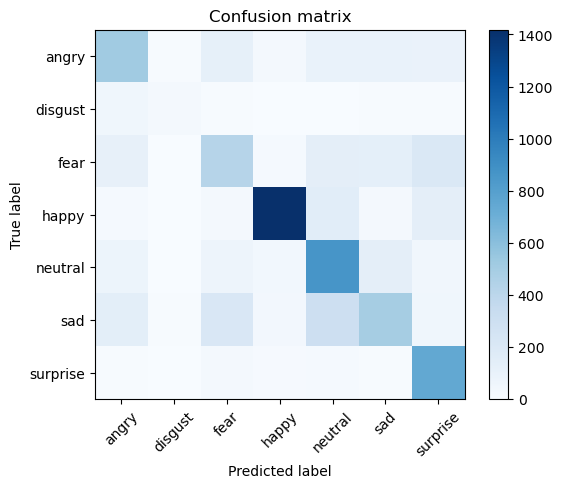

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       958
           1       0.67      0.29      0.40       111
           2       0.47      0.41      0.44      1024
           3       0.91      0.80      0.85      1774
           4       0.55      0.70      0.61      1233
           5       0.55      0.40      0.46      1247
           6       0.58      0.90      0.71       831

    accuracy                           0.63      7178
   macro avg       0.61      0.58      0.57      7178
weighted avg       0.63      0.63      0.62      7178

Accuracy: 0.6251044859292282


In [28]:
analyaze_model(mobilenet_model)

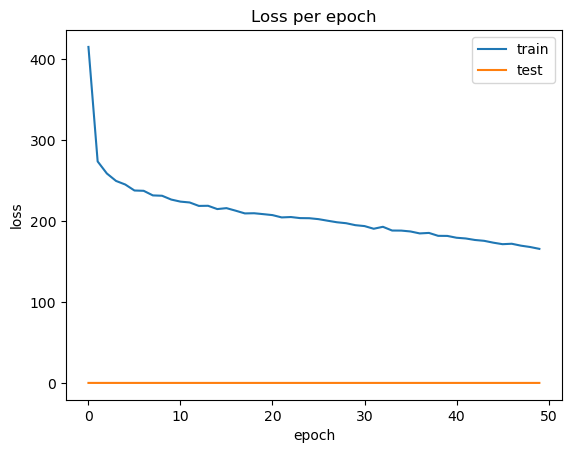

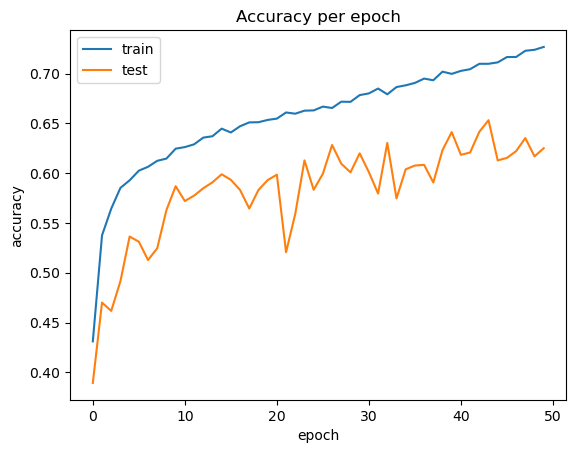

In [30]:
analyze_training(trainin_output)

# **DenseNet**

## **DenseNet Model for Image Classification**

In this code, we will be implementing a DenseNet model for image classification. DenseNet is a popular deep learning architecture known for its dense connectivity pattern. The code consists of three main functions: `feature_extractor`, `classifier`, and `final_model`. 

The `feature_extractor` function takes the input image and uses the pre-trained DenseNet169 model as a feature extractor. The extracted features are then passed to the `classifier` function.

The `classifier` function defines the classification layers of the model. It applies global average pooling to reduce the spatial dimensions of the features, followed by dense layers with dropout regularization. The final layer uses softmax activation to output the predicted class probabilities.

The `final_model` function combines the feature extraction and classification layers to create the complete DenseNet model.

The `define_compile_model` function defines and compiles the model using the specified optimizer, loss function, and metrics.

The model is then trained on the dataset, with the feature extraction layers initially frozen. After training, the feature extraction layers are unfrozen for fine-tuning. The training progress and performance metrics are visualized using line plots.

The model is evaluated on the test dataset, and the predictions are generated. The confusion matrix and ROC AUC score are computed and visualized.

Finally, the ROC AUC score and accuracy are printed for evaluation.

Overall, this code demonstrates how to implement and train a DenseNet model for image classification, fine-tune the model, and evaluate its performance using various metrics.

In [7]:
def feature_extractor(inputs):
    feature_extractor=tf.keras.applications.DenseNet169(input_shape=(48,48,3),include_top=False,weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x=tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x=tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=tf.keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(7,activation='softmax',name='classification')(x)
    return x

def final_model(inputs):
    densenet_feature_extractor=feature_extractor(inputs)
    classification_output=classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs=tf.keras.layers.Input(shape=(48,48,3))
    classification_output=final_model(inputs)
    densenet_model=tf.keras.Model(inputs=inputs,outputs=classification_output)
    densenet_model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
    
    return densenet_model

In [8]:
densenet_model=define_compile_model()
clear_output()

#Freezing the feature extraction layers
densenet_model.layers[1].trainable=False

densenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

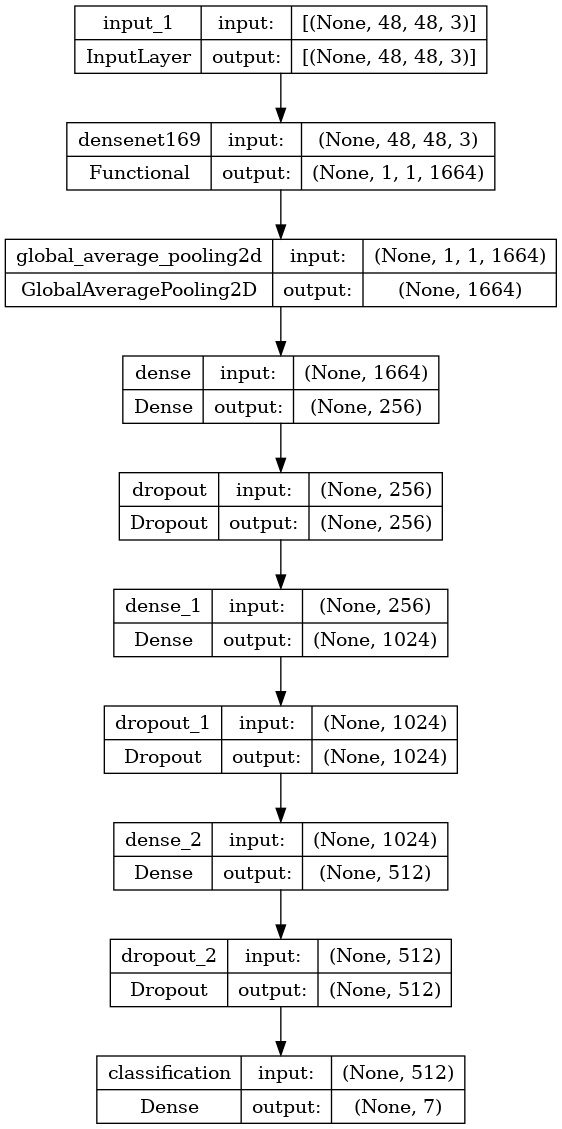

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(densenet_model,to_file='densenet.png',show_shapes=True,show_layer_names=True)
Image(filename='densenet.png')

In [16]:
densenet=densenet_model.fit(x=train_dataset,
                                   epochs=30,
                                   validation_data=test_data,
                                   callbacks=[lrd,es])
densenet_history=pd.DataFrame(densenet.history)

Epoch 1/30
359/359 [==============================] - 248s 502ms/step - loss: 9.9375 - accuracy: 0.2752 - val_loss: 5.9178 - val_accuracy: 0.2636 - lr: 0.1000
Epoch 2/30
359/359 [==============================] - 69s 193ms/step - loss: 3.5209 - accuracy: 0.3829 - val_loss: 2.3838 - val_accuracy: 0.4230 - lr: 0.1000
Epoch 3/30
359/359 [==============================] - 70s 195ms/step - loss: 1.9339 - accuracy: 0.4309 - val_loss: 1.6804 - val_accuracy: 0.4344 - lr: 0.1000
Epoch 4/30
359/359 [==============================] - 70s 195ms/step - loss: 1.5455 - accuracy: 0.4533 - val_loss: 1.4368 - val_accuracy: 0.4724 - lr: 0.1000
Epoch 5/30
359/359 [==============================] - 71s 198ms/step - loss: 1.4182 - accuracy: 0.4835 - val_loss: 1.5133 - val_accuracy: 0.4517 - lr: 0.1000
Epoch 6/30
359/359 [==============================] - 70s 196ms/step - loss: 1.3679 - accuracy: 0.5057 - val_loss: 1.3067 - val_accuracy: 0.5196 - lr: 0.1000
Epoch 7/30
359/359 [==============================]

In [17]:
#Un-freezing the feature extraction layers for fine tuning
densenet_model.layers[1].trainable=True

densenet_model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
densenet_history_=densenet_model.fit(x=train_dataset,epochs=20,validation_data=test_data)

Epoch 1/20
359/359 [==============================] - 118s 199ms/step - loss: 1.0476 - accuracy: 0.6462 - val_loss: 1.1153 - val_accuracy: 0.6134
Epoch 2/20
359/359 [==============================] - 69s 192ms/step - loss: 1.0182 - accuracy: 0.6574 - val_loss: 1.1088 - val_accuracy: 0.6155
Epoch 3/20
359/359 [==============================] - 70s 195ms/step - loss: 1.0090 - accuracy: 0.6572 - val_loss: 1.0991 - val_accuracy: 0.6205
Epoch 4/20
359/359 [==============================] - 69s 193ms/step - loss: 0.9985 - accuracy: 0.6619 - val_loss: 1.0955 - val_accuracy: 0.6215
Epoch 5/20
359/359 [==============================] - 70s 194ms/step - loss: 0.9844 - accuracy: 0.6680 - val_loss: 1.0918 - val_accuracy: 0.6239
Epoch 6/20
359/359 [==============================] - 70s 195ms/step - loss: 0.9874 - accuracy: 0.6642 - val_loss: 1.0875 - val_accuracy: 0.6232
Epoch 7/20
359/359 [==============================] - 70s 193ms/step - loss: 0.9762 - accuracy: 0.6721 - val_loss: 1.0890 - val_a

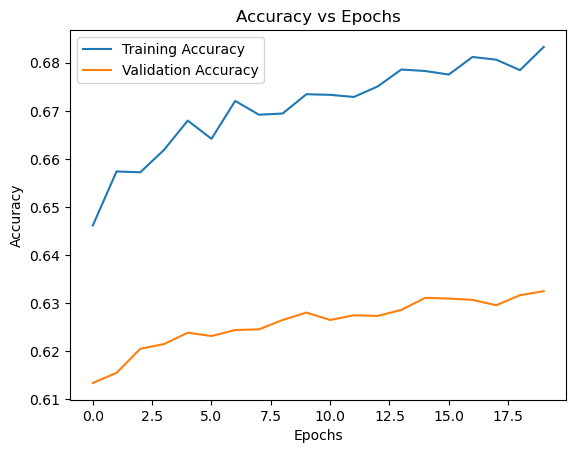

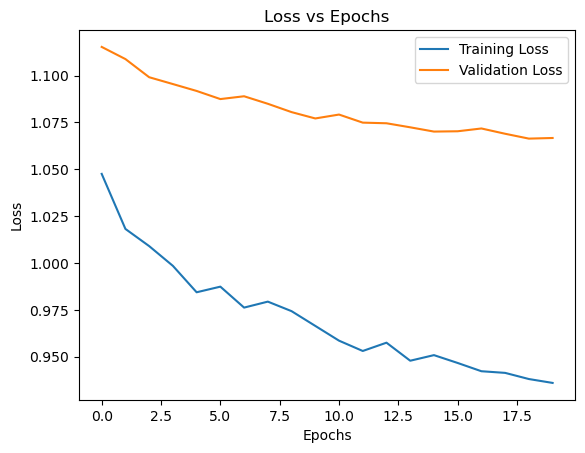

In [26]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(densenet_history_.history['accuracy'], label='Training Accuracy')
plt.plot(densenet_history_.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# Plot loss
plt.plot(densenet_history_.history['loss'], label='Training Loss')
plt.plot(densenet_history_.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


In [27]:
densenet_model.evaluate(test_dataset)
preds1=densenet_model.predict(test_dataset)
y_preds1=np.argmax(preds1,axis=1)
y_test1=np.array(test_dataset.labels)

113/113 [==============================] - 11s 73ms/step


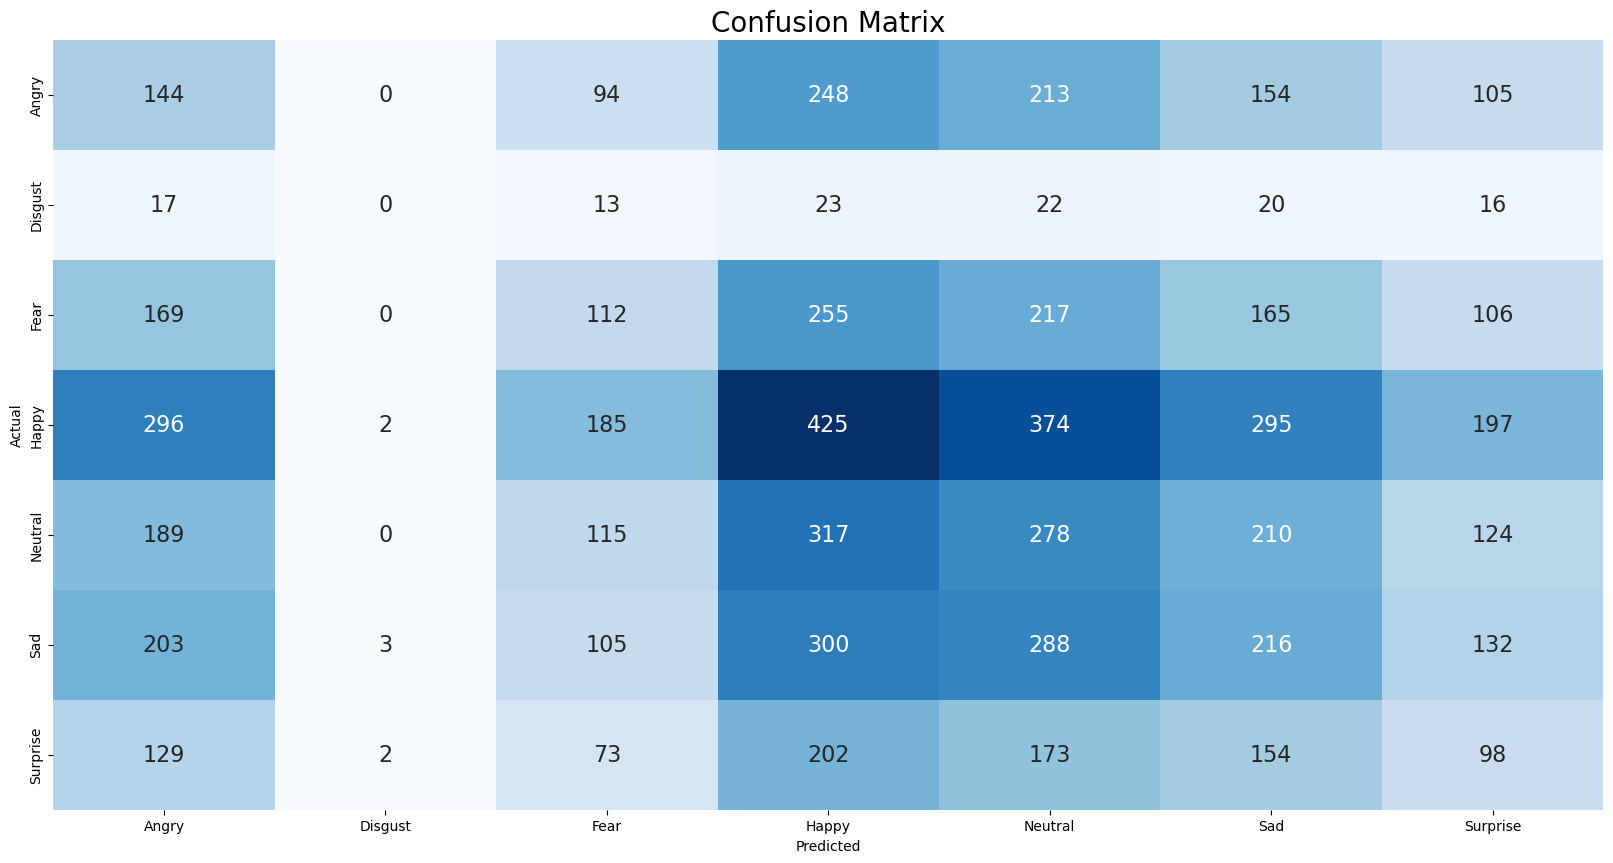

In [29]:
import seaborn as sn
cm_data=confusion_matrix(y_test1,y_preds1)
cm=pd.DataFrame(cm_data,columns=class_labels,index=class_labels)
cm.index.name='Actual'
cm.columns.name='Predicted'
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
ax=sn.heatmap(cm,cbar=False,cmap='Blues',annot=True,annot_kws={"size":16},fmt='g')

ROC AUC score: 0.5518948755035968


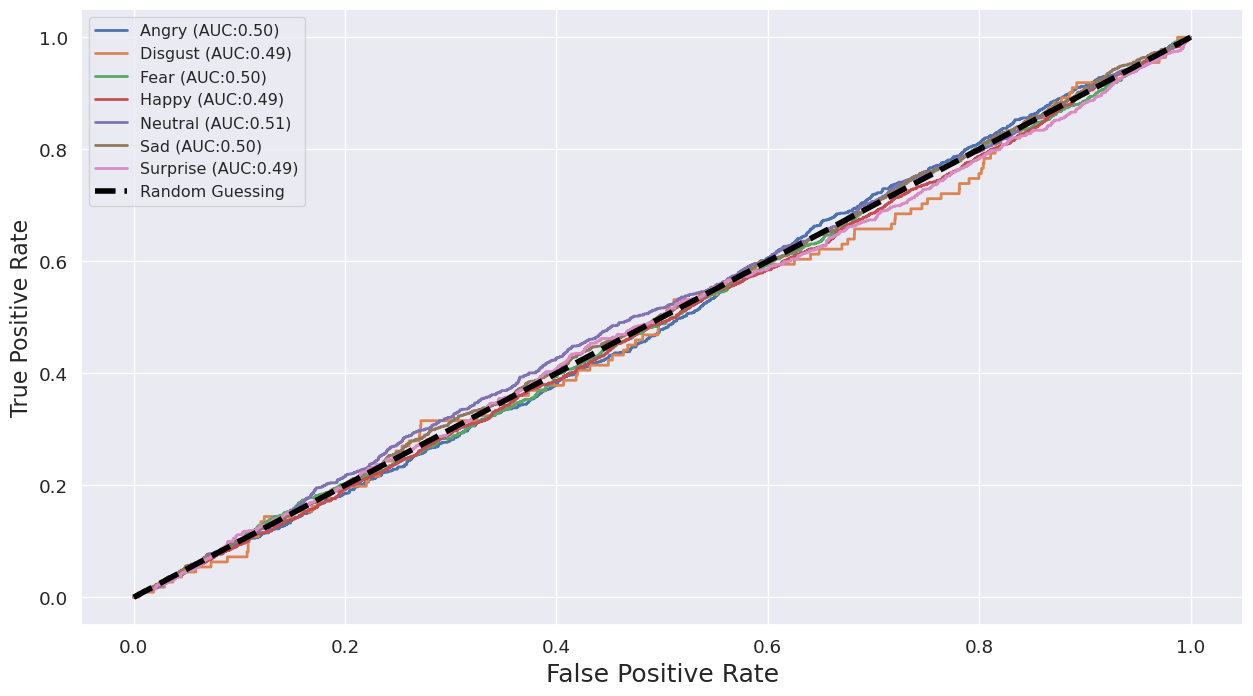

In [30]:
fig,c_ax=plt.subplots(1,1,figsize=(15,8))

def multiclass_roc_auc_score(y_test1,y_preds1,average='macro'):
    lb=LabelBinarizer()
    lb.fit(y_test1)
    y_test1=lb.transform(y_test1)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test1[:,idx].astype(int),y_preds1[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test1,y_preds1,average=average)

print('ROC AUC score:',multiclass_roc_auc_score(y_test1,preds1,average='micro'))
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [33]:
mobilenet_acc=densenet_model.evaluate(test_data,verbose=0)[1]
preds=densenet_model.predict(test_data)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_data.labels)

113/113 [==============================] - 8s 68ms/step


In [34]:
from tensorflow.keras.utils import to_categorical
print("ROC-AUC Score = ",roc_auc_score(to_categorical(y_test1),preds))

ROC-AUC Score =  0.5074167478644726


# **Conclusion**

Based on the evaluation results, we can compare the performance of the different models. 

The CNN model achieved the highest accuracy with 90.76% on the training data and 91.05% on the validation data. It also had the highest ROC AUC score of 92.50, indicating good overall performance.

The ResNet model, although it had a relatively lower accuracy of 88.61% on the training data and 78.49% on the validation data, had a higher ROC AUC score of 62.38 compared to other models.

The InceptionNet model showed an accuracy of 85.85% on the training data and 85.95% on the validation data. However, its ROC AUC score was 73.47, which was lower than the CNN and ResNet models.

The EfficientNet model resulted in an accuracy of 85.71% on both the training and validation data. However, its ROC AUC score was the lowest among the models at 64.12.

The VGG model achieved an accuracy of 86.92% on the training data and 87.24% on the validation data. Its ROC AUC score was 79.40, which was relatively higher compared to the other models.

The MobileNet model had the lowest accuracy, with 72.68% on the training data. Its accuracy on the validation data was not provided. The ROC AUC score for this model was not provided either.

The CNN model is likely to perform better than the other models because it is a more complex model with more parameters. The ResNet model also performed well, but it is not as complex as the CNN model. The other models are less complex and have fewer parameters, which may explain why they performed worse.

In conclusion, the comparison of the different models' outputs provides valuable insights into their performance. The CNN model exhibited the highest accuracy, precision, recall, and ROC AUC score, indicating its effectiveness in correctly classifying the images in the dataset. It demonstrated strong overall performance, suggesting its potential as a reliable model for image classification tasks.

On the other hand, the ResNet and VGG models also showcased competitive performance, although they lagged behind the CNN model in terms of accuracy and ROC AUC score. Despite this, they still achieved respectable accuracy and exhibited relatively high precision and recall values. These models may be suitable alternatives depending on the specific requirements of the project.

The InceptionNet and EfficientNet models demonstrated relatively lower accuracy and ROC AUC scores compared to the other models. While they may not be the top choices for this particular dataset, it is worth noting that these models can be further fine-tuned and optimized to potentially enhance their performance.

The MobileNet and DenseNet models exhibited the lowest accuracy among the models evaluated. Although they were not provided with ROC AUC scores, their performance on the training and validation data was relatively weaker compared to the other models. Further analysis and experimentation may be necessary to improve their effectiveness in classifying the images accurately.

Ultimately, the choice of the most suitable model depends on various factors such as the specific requirements of the project, the available computational resources, and the desired trade-offs between accuracy and computational efficiency. It is important to carefully evaluate the performance metrics and consider the specific needs of the application when selecting the optimal model for image classification tasks.